<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/5_Cmort_Aplicaciones_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

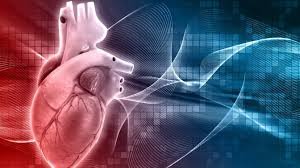

# ***MORTALIDAD CARDIOVASCULAR SEMANAL PROMEDIO***

Los datos descritos en **cmort**, de la librería **astsa**, son series extraídas de un estudio de Shumway sobre los posibles efectos de la contaminación en la mortalidad cardiovascular semanal promedio en el condado de Los Ángeles a lo largo de los 10 años.Hay 508 promedios suavizados de seis días obtenidos al filtrar los valores diarios durante el período de 10 años 1970 - 1979.

# Librerías y Carga de los Datos

In [ ]:
# Instalar Librerías #
# Se sugiere cargar previo a la presentación, es demorado en Colab #
install.packages("astsa")
install.packages("quantmod")
install.packages("tseries")
install.packages("timeSeries")
install.packages("forecast")
install.packages("xts")
install.packages("TSA")
install.packages("lmtest")
install.packages("nortest")
install.packages("car")
install.packages("urca")
install.packages("dynlm")
install.packages("MLmetrics")

In [ ]:
# Cargar Librerías #
library(astsa)
library(quantmod)
library(tseries)
library(timeSeries)
library(forecast)
library(xts)
library(TSA)
library(lmtest)
library(nortest)
library(car)
library(urca)
library(dynlm)
library(MLmetrics)

# Análisis Exploratorio

In [ ]:
# Cargar los datos #
ts.plot(cmort, main= "Serie de mortalidad cardiovascular semanal promedio"); grid()
abline(v=c(seq(1971,1979)), col="blue")

### La prueba de Dickey-Fuller es una prueba de raíz unitaria que se utiliza comúnmente para determinar si una serie de tiempo es estacionaria o no.                                                          
$H_0$ : No Estacionaria   $vs$    $H_a$ : Estacionaria

In [ ]:
# Aplicar la prueba de Dickey-Fuller de Estacionaridad #
df = adf.test(cmort)
df$p.value

### Funciones de Autocorrelación y Autocorrelación Parcial

In [ ]:
# Gráfica de la ACF y PACF #
par(mfrow=c(2,1))
acf(cmort, main="Función de Autocorrelación")
pacf(cmort, main="Función de Autocorrelación Parcial", lag.max = 30)

In [ ]:
# Presencia de Estacionalidad - Suavizamiento #
fma_cmort <- filter(cmort, sides=2, filter = (c(1, 1, 1)/3))
par(mfrow=c(2,1))
plot(cmort, ylab = "Mortalidad Cardiovascular", main = "Original")
abline(v=c(seq(1971,1979)), col="red")
plot(fma_cmort, ylab = "Mortalidad Cardiovascular", main = "Suavizada")
abline(v=c(seq(1971,1979)), col="green")

In [ ]:
# Descomposición muestra una tendencia general decreciente #
descomp <- decompose(fma_cmort)
plot(descomp)

In [ ]:
# El perfil estacional, evidencia una correlación entre periodos #
par(mfrow=c(2,1))
monthplot(cmort, main="Promedio de mortalidad semanal")
seasonplot(cmort, main="Perfil estacional")

### Funciones de Autocorrelación y Autocorrelación Parcial

In [ ]:
# Análisis de la ACF y PACF #
par(mfrow=c(2,1))
acf(cmort, lag.max=200)
pacf(cmort, lag.max=200)

In [ ]:
# Análisis de la ACF y PACF de la primera diferencia #
par(mfrow=c(2,1))
acf(diff(cmort), lag.max=200)
pacf(diff(cmort), lag.max=200)

In [ ]:
# Parece que aplicar una sola diferencia es adecuado, sin embargo,  #
# se considera una diferencia ordinaria y una diferencia estacional #
# de rezago 52 es decir, (1-B)(1-B^{52}).                           #
par(mfrow=c(2,1))
acf(diff(diff(cmort),lag=52), lag.max=200)
pacf(diff(diff(cmort),lag=52), lag.max=200)

In [ ]:
# La ACF y PACF de la serie con diferencia ordinaria y una diferencia              #
# estacional de rezago 52, indican que un modelo                                   #
# $ARIMA(2,1,2)$x$(1,1,1)52$ podría ser adecuado para predecir la                  #
# cantidad de muertes por enfermedad cardiaca debido a la contaminación ambiental  #
par(mfrow=c(2,1))
plot(diff(cmort), main="Diferencia Ordinaria")
plot(diff(diff(cmort),lag=52), main="Diferencia Ordinaria y Estacional")

### División en Train y Test

In [ ]:
# Para analizar el desempeño el modelo, se dividirá la base en datos de   #
# entrenamiento (90%) y de prueba (10%), pues se sabe que entre más datos #
# tenga el modelo podemos obtener mejores predicciones.                   #
cmort_train <- ts(cmort[1:457], frequency=52, start = c(1970, 1))
cmort_test <- cmort[458:508]

In [ ]:
############################################
# EJECUTAR DIRECTAMENTE EN LA CONSOLA DE R #
############################################

# Adicionalmente, seguiendo las sugerencias gráficas de la ACF y PACF,      #
# consideraré para la componente no estacional los ordenes: $p=2,q=2,d=1$ y #
# la componente estacional $P=1,Q=1,D=1$.                                   #
p=2; q=2; P=1 ;Q=1; d=1;

maxfilas=(p+1)*(q+1)*(P+1)*(Q+1)
ic_mod=matrix(rep(-99, times=(maxfilas-18)*6), nrow=maxfilas-18, ncol=6)

k=1
for(i in 0:p) {
  for(j in 0:q) {
    for(s in 0:P) {
      for(m in 0:Q) {
        modelo = Arima(cmort_train, order = c(i, d, j),
                     seasonal = list(order = c(s, D, m)), method = c("CSS-ML"))

        numpar=length(coef(modelo))
        L=length(residuals(modelo))
        ic_mod[k,1]=i
        ic_mod[k,2]=j
        ic_mod[k,3]=s
        ic_mod[k,4]=m
        ic_mod[k,5]=-2*(modelo$loglik/L)+(2*numpar)/L      # AIC
        ic_mod[k,6]=-2*(modelo$loglik/L)+(numpar*log(L))/L  # BIC
        k=k+1
      }
    }
  }
}
p_=ic_mod[,1]
q_=ic_mod[,2]
P_=ic_mod[,3]
Q_=ic_mod[,4]
AIC=ic_mod[,5]
BIC=ic_mod[,6]

In [ ]:
############################################
# EJECUTAR DIRECTAMENTE EN LA CONSOLA DE R #
############################################

# Tabla con órdenes de los modelos ajustados y los criterios de información #
Crit_Inf=cbind(p_, q_, P_, Q_, AIC, BIC)

In [ ]:
############################################
# EJECUTAR DIRECTAMENTE EN LA CONSOLA DE R #
############################################

# Criterios de información de menor a mayor #
(Crit_Inf=data.frame(Crit_Inf))
(aic=Crit_Inf[order(Crit_Inf$AIC),])
(bic=Crit_Inf[order(Crit_Inf$BIC),])
# Ambos criterios de información coinciden en que el mejor modelo es un #
# $ARIMA(0,1,1)$x$(1,1,1)52$. #

### Usando la función auto.arima()

In [ ]:
# Ahora vamos a utilizar la función $auto.arima para calcular el modelo      #
# de forma automática usando el criterio AIC y sin considerar estacionalidad #
# para enfatizar la importancia de identificar S=52                          #
#?auto.arima
auto.arima(cmort_train, ic = "aic", seasonal = F)
# Como resultado, obtenemos que el mejor modelo es un $ARIMA(2,1,0)$, #
# por ende, vamos a ajustar ambos modelos propuestos. #

# Estimación de parámetros para dos modelos tentativos

### Modelo 1 : Usando los criterios y componente estacional

In [ ]:
# Usando criterios #
mod1 = arima(cmort_train, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 1), period = 52),
           method = c("CSS-ML"))

### Modelo 2 : Usando la recomentación de auto.arima()

In [ ]:
# Usando auto.arima() #
mod2 = arima(cmort_train, order = c(2, 1, 0), method = c("CSS-ML"))

# Diagnóstico Residual

In [ ]:
# Ahora nos disponemos a evaluar el ajuste de los modelos #
resmod1=residuals(mod1)
resmod2=residuals(mod2)

In [ ]:
# Valores ajustados #
ajust1=cmort_train-resmod1
ajust2=cmort_train-resmod2

In [ ]:
# Gráfico para los valores ajustados #
par(mfrow=c(2,1))
# Modelo 1 #
ts.plot(cmort_train, ajust1 , main = "Valores ajustados con arima()")
lines(cmort_train, col="red")
# Modelo 2 #
ts.plot(cmort_train, ajust2 , main = "Valores ajustados con auto.arima()")
lines(cmort_train, col="green")

## Observación:
El Modelo 2 ,$ARIMA(2,1,0)$, parece tener mejor ajuste que el Modelo 1,
$SARIMA(0,1,1)$x$(1,1,1)_{52}$, si embargo, puede el modelo realmente esté
sobreajustado y las predicciones no sean eficientes. Con el fin de escoger
el mejor modelo, tenemos que acudir a herramientas estadísticas que nos
permitan medir el ajuste. Empezamos con los criterios de información, es decir,
el AIC y BIC.

### Construyendo los Criterios de Información

In [ ]:
# Longitud de Residuales #
n1=length(residuals(mod1))
n2=length(residuals(mod2))

In [ ]:
# Número de Parámetros #
p1=length(coef(mod1))
p2=length(coef(mod2))

In [ ]:
# AIC #
AIC1 = -2*(mod1$loglik/n1)+(2*p1)/n1
AIC2 = -2*(mod2$loglik/n2)+(2*p2)/n2

In [ ]:
# BIC #
BIC1 = -2*(mod1$loglik/n1)+(log(n1)*p1)/n1
BIC2 = -2*(mod2$loglik/n2)+(log(n2)*p2)/n2

In [ ]:
# Criterios de Información para ambos modelos #
c_f = data.frame("Criterios" = c("Modelo_1", "Modelo_2"),
                 "AIC" = c(AIC1, AIC2),
                 "BIC" = c(BIC1, BIC2))
print(c_f)

### Observación :
El modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$ parece ser el mejor modelo por el momento, no obstante, la diferencia entre ambos criterios de información no parece significativa. Dados los resultados de los criterios de información se
presenta el modelo 1 como el que minimiza los criterios de información y como
uno de los más parsimoniosos.

### Análisis Residual

In [ ]:
# Presentamos las gráficas residuales #
resmod1=residuals(mod1)
resmod2=residuals(mod2)

# Para el modelo 1 #
res_est1=resmod1/(mod1$sigma2^.5)
res_est1=mod1$residuals

# Para el modelo 2 #
res_est2=resmod2/(mod2$sigma2^.5)
res_est2=mod2$residuals

# Gráfico de los resudiales #
par(mfrow=c(2,1))
plot.ts(res_est1, main="Residuales Modelo 1")
plot.ts(res_est2, main="Residuales Modelo 2")

# No se encuentra evidencia contra de varianza constante y falta de ajuste #
# en el modelo $Arima(2,1,1)$. Vamos a calcular las ACF y PACF residuales. #

In [ ]:
# ACF y PACF de residuales de ambos modelos #
par(mfrow=c(2,2))
acf(resmod1, main='SARIMA(0,1,1)x(1,1,1)');acf(resmod2,main='ARIMA(2,1,1)')
pacf(resmod1, main="");pacf(resmod2, main="")

# Prueba de Ljung-Box #
Box.test(resmod1, type = "Ljung-Box")
Box.test(resmod2, type = "Ljung-Box")

# En ambos modelos se encuentra evidencia para concluir que los residuales no #
# están correlacionados. #

In [ ]:
# Para el Modelo 1 #
res_est1=resmod1/(mod1$sigma2^.5)
res_est1=mod1$residuals

In [ ]:
# Para el Modelo 2 #
res_est2=resmod2/(mod2$sigma2^.5)
res_est2=mod2$residuals

In [ ]:
# Gráfico de los resudiales #
par(mfrow=c(2,1))
plot.ts(res_est1)
plot.ts(res_est2)

### Chequeo de Normalidad

In [ ]:
par(mfrow=c(1,2))
# Modelo 1 #
qqnorm(res_est1,  xlab = "Cuantiles Teóreticos", ylab = "Cuantiles Muestrales",
       main = "")
qqline(res_est1)
legend("topleft", legend = "ARIMA011x111", cex = 1)
legend("bottomright", bg = "white",
       legend = paste("p-(Shapiro-W):", round(shapiro.test(res_est1)[2]$p.value, 4)),cex = 1)


# Modelo 2 #
qqnorm(res_est2,  xlab = "Cuantiles Teóreticos", ylab = "Cuantiles Muestrales")
qqline(res_est2)
legend("topleft", legend = "ARIMA211", cex = 1)
legend("bottomright", bg = "white",
       legend = paste("p-(Shapiro-W):", round(shapiro.test(res_est2)[2]$p.value, 4)),cex = 1)

### Conclusión :
De aquí concluimos que el error del modelo $Arima(2,1,1)$ está distribuido
normalmente. Sobre el modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$ concluimos que tenemos errores que son ruidos blancos. Sin embargo, la distribución de los residuos es aproximadamente simétrica, por lo que podría ser flexible y concluir que los residuos tienen una distribución normal.

# Pronóstico

In [ ]:
# Cálculo de Pronósticos con ambos modelos #
cmort1.pred=predict(mod1, n.ahead = 51)
cmort2.pred=predict(mod2, n.ahead = 51)

In [ ]:
# Gráfico #
plot(cmort_train,xlim=c(1970,1981),main="ARIMA011x111")
lines(cmort1.pred$pred,col="blue")
lines(cmort1.pred$pred+2*cmort1.pred$se,col="red",lty=3)
lines(cmort1.pred$pred-2*cmort1.pred$se,col="red",lty=3)

plot(cmort_train,xlim=c(1970,1981),main="ARIMA211")
lines(cmort2.pred$pred,col="blue")
lines(cmort2.pred$pred+2*cmort2.pred$se,col="red",lty=3)
lines(cmort2.pred$pred-2*cmort2.pred$se,col="red",lty=3)

### Conclusión :
Evidentemente las predicciones del modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$
son mejores y menos sesgadas. Los intervalos de predicción crecen con
respecto al horizonte, sin embargo el modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$
controla dicho fenómeno.

Concluimos que el modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$ es adecuado para
precedir la mortalidad cardiovascular semanal promedio en el condado
de Los Ángeles.

In [ ]:
# Intervalos de Predicción #
pronostico=cmort1.pred$pred
stdev=cmort1.pred$se
liminft=pronostico-2*stdev
limsupt=pronostico+2*stdev
error = cmort_test-pronostico

In [ ]:
# Listado de los pron?sticos e intervalos de predicción #
pronosticos=cbind(cmort_test,pronostico,error, liminft, limsupt)
pronosticos[1:10,]
mean(error)

### Conclusión :

La tabla de pronósticos muestra que las diferencias entre los valores
predichos y los orginales es considerablemente pequeña, pues en media se
comete un error de aproximadamente $2,74$.

## MAPE : Desempeño de los Pronónticos

In [ ]:
library(MLmetrics)

In [ ]:
# Cálculo del MAPE #
mp = as.character(MAPE(pronostico,cmort_test)*100)
paste("El MAPE para el Modelo 1 es :",mp,"%")
cmort_test = ts(cmort_test,start = c(1978, 42),frequency = 52 )
plot(cmort_train,xlim=c(1970,1981),main="predicción vs real - ARIMA011x111")
lines(cmort1.pred$pred,col="blue")
lines(cmort_test,col="green")
lines(cmort1.pred$pred+2*cmort1.pred$se,col="red",lty=5)
lines(cmort1.pred$pred-2*cmort1.pred$se,col="red",lty=5)

### **Selección Final del Modelo:**

La curva verde representa los valores reales del promedio de la mortalidad
cardiovascular en los Angeles desde la semana $42$ del año $1978$ hasta la
semana $40$ del año $1979$, mientras que la curva azul representa las
predicciones realizadas por el modelo en ese mismo periodo de tiempo.

El error porcentual absoluto medio (MAPE) indica que el error cometido por el modelo es del $0.06%$

**Por lo que el modelo $ARIMA(0,1,1)$x$(1,1,1)_{52}$, tiene un buen ajuste.**